In [10]:
import torch
import numpy as np
import mediapipe as mp
from torchvision.io import read_video
from torch.utils.data import Dataset, DataLoader
import random
import os

In [18]:
MODELS_DIR = "/models/"

Data preparation

In [12]:
class VideoDataset(Dataset):
    def __init__(self, data_path, packet_len):
        self.data_folder = data_path
        self.n_frames_per_batch = packet_len

        # Get the list of subfolders (classes)
        self.classes = sorted(os.listdir(data_path))

        # Map classes to numeric indices
        self.class_to_index = {cls: idx for idx, cls in enumerate(self.classes)}

        # List to store video paths and their labels
        self.data = []

        # Iterate through subfolders and create the data list
        for cls in self.classes:
            cls_path = os.path.join(data_path, cls)
            if os.path.isdir(cls_path):
                videos = os.listdir(cls_path)
                for video in videos:
                    video_path = os.path.join(cls_path, video)
                    self.data.append((video_path, self.class_to_index[cls]))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        video_path, label = self.data[index]
        coordinates_tensor = self.preprocess(video_path, self.n_frames_per_batch)

        return coordinates_tensor, label

    def extract_pose(self, frame_package):
        mp_pose = mp.solutions.pose
    
        # Inference poses in the frame package using mediapipe
        with mp_pose.Pose(min_detection_confidence=0.4, min_tracking_confidence=0.4) as pose:
            pose_data = []
            for frame in frame_package:
                frame = frame.permute(1, 2, 0)
                result = pose.process(np.array(frame).astype(np.uint8))
    
                # Check if pose is detected
                if result.pose_landmarks:
                    # Extract relative coordinates of landmarks
                    landmarks = [[landmark.x, landmark.y, landmark.z] for landmark in result.pose_landmarks.landmark]
                else:
                    # If no pose is detected, set all landmarks to 0
                    landmarks = [[0, 0, 0] for _ in range(33)]
    
                pose_data.append(landmarks)
    
        return pose_data

    def preprocess(self, video_path, n):
        # Read the video using torchvision
        video, _, _ = read_video(video_path, pts_unit='sec')
    
        # Total number of frames in the video
        total_frames = video.size(0)
    
        # Ensure that the video has at least 'n' frames
        if total_frames < n:
            raise ValueError(f"The video has fewer than {n} frames.")
    
        # Randomly select the starting index for the segment
        start_idx = random.randint(0, total_frames - n)
    
        if start_idx + n > total_frames:
            start_idx = start_idx - (start_idx + n - total_frames)
    
        # Extract the frame package from the randomly selected segment
        frame_package = video[start_idx:start_idx + n].permute(0, 3, 1, 2)
    
        pose_data = self.extract_pose(frame_package)
    
        return torch.tensor(pose_data)

In [13]:
from torch.utils.data import random_split


def load_data(data_folder, len_package, batch_size, shuffle=True):
    # Assuming VideoDataset is your custom dataset class
    dataset = VideoDataset(data_folder, len_package)

    # Calculate sizes for train, validation, and test sets
    total_size = len(dataset)
    train_size = int(0.8 * total_size)
    val_size = (total_size - train_size) // 2
    test_size = total_size - train_size - val_size

    # Use random_split to split the dataset
    train_dataset, val_dataset, test_dataset = random_split(
        dataset, [train_size, val_size, test_size]
    )
    train_data_loader =DataLoader(train_dataset, batch_size=batch_size, shuffle=shuffle)
    val_data_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=shuffle)
    test_data_loader =DataLoader(test_dataset, batch_size=batch_size, shuffle=shuffle)
    
    return train_data_loader, val_data_loader, test_data_loader

# Example usage
data_folder = "data"  # Path to the folder containing subfolders for each class
frames_per_package = 10
batch_size = 64
train_dataloader, val_dataloader, test_dataloader = load_data(data_folder, frames_per_package, batch_size, shuffle=True)

Net architectures

Vamos a hacer 3 arquitecturas de distintos tamaños. Se trata solo de la capa fully conected.

In [14]:
from torch import nn

class Model(nn.Module):
    def __init__(self,frames_per_package, num_classes):
        super(Model, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(frames_per_package * 33 * 3, 3000)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(3000,300)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(300, num_classes)
        self.softmax = nn.Softmax(dim=1)
        
    def forward(self, x):
        x = self.flatten(x)
        x = self.relu1(self.fc1(x))
        x = self.relu2(self.fc2(x))
        out = self.softmax(self.fc3(x))
        return out

In [23]:
import numpy as np

def accuracy(all_labels, all_pred):
    correct_predictions = np.sum(np.array(all_labels) == np.array(all_pred))
    total_predictions = len(all_labels)
    accuracy = correct_predictions / total_predictions
    return accuracy

# función de entrenamiento
def train(dataloader, model, loss_fn, optimizer):

    model.train()
    all_pred = []
    all_labels = []
    total_loss = 0

    for batch, (inputs, labels) in enumerate(dataloader):

        inputs, labels = inputs.to(device), torch.tensor(labels).to(device)
        optimizer.zero_grad()

        # Compute prediction error
        pred = model(inputs)
        loss = loss_fn(pred, labels)
        total_loss += loss.item()

        # Backpropagation
        loss.backward()
        optimizer.step()
        _ ,pred_classes = torch.max(pred, 1)

        all_pred.extend(pred_classes.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

    acc = accuracy(all_labels, all_pred)
    mean_loss = total_loss/len(dataloader)

    print(f"Training accuraccy: {acc:.4f} | Training mean_loss: {mean_loss:.4f}\n-------------------------------")

    return acc, mean_loss

#Validate and Test Func
def validate(dataloader, model, loss_fn):

    model.eval()

    all_pred = []
    all_labels = []
    total_loss = 0

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            pred = model(inputs)
            loss = loss_fn(pred, labels)
            _ ,pred_classes = torch.max(pred, 1)

            all_pred.extend(pred_classes.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            total_loss += loss.item()

    acc = accuracy(all_labels, all_pred)
    return acc, total_loss/len(dataloader)

import matplotlib.pyplot as plt

def draw_metrics(train_acc, val_acc, train_loss, val_loss):
    fig, (ax1, ax3) = plt.subplots(1, 2, figsize=(18, 6))

    # Graficar train_acc y val_acc en la primera subtrama
    ax1.plot(train_acc, label='train_acc', color='blue')
    ax1.plot(val_acc, label='val_acc', color='green')
    ax1.set_title('Train vs Validation Accuracy')
    ax1.set_xlabel('Época')
    ax1.set_ylabel('Precisión')
    ax1.legend()

    # Graficar train_loss y val_loss en la tercera subtrama
    ax3.plot(train_loss, label='train_loss', color='blue')
    ax3.plot(val_loss, label='val_loss', color='green')
    ax3.set_title('Train vs Validation Loss')
    ax3.set_xlabel('Época')
    ax3.set_ylabel('Pérdida')
    ax3.legend()

    # Ajustar el espaciado entre las subtramas
    plt.tight_layout()

    # Mostrar el gráfico
    plt.show()

In [16]:
from torch import optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Model(frames_per_package, num_classes=22)
model.to(device)


# Define the loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer)

# Number of epochs
EPOCHS = 10

# Lists to store training and validation results
train_acc = []

train_loss = []


val_acc = []

val_loss = []

for t in range(EPOCHS):
    print(f"Epoch {t + 1}/{EPOCHS}\n-------------------------------")

    # Training phase
    acc, loss = train(train_dataloader, model, loss_fn, optimizer)

    train_acc.append(acc)
    train_loss.append(loss)

    # Validation phase
    acc, loss = validate(val_dataloader, model, loss_fn)
    val_acc.append(acc)
    val_loss.append(loss)
    scheduler.step(loss)

    print(f"Validation accuraccy: {acc:.3f} | Validation mean_loss: {loss:.4f}\n-------------------------------")


print("Training and Validation Done!")

test_acc, test_loss = validate(test_dataloader, model, loss_fn)

print(f"Test accuraccy: {test_acc:.3f}| Test loss: {test_loss:.3f}\n-------------------------------")

# Save the trained model
torch.save(model.state_dict(), "models\\model.pth")
print("Model saved as model_cnn.pth")
draw_metrics(train_acc, val_acc, train_loss, val_loss)

Epoch 1/10
-------------------------------


C:\Users\adria\AppData\Local\Temp\ipykernel_21120\2231422014.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs, labels = inputs.to(device), torch.tensor(labels).to(device)


Training accuraccy: 0.0729 | Training mean_loss: 3.0907
-------------------------------
Validation accuraccy: 0.092 | Validation mean_loss: 3.0913
-------------------------------
Epoch 2/10
-------------------------------
Training accuraccy: 0.0845 | Training mean_loss: 3.0908
-------------------------------
Validation accuraccy: 0.062 | Validation mean_loss: 3.0906
-------------------------------
Epoch 3/10
-------------------------------
Training accuraccy: 0.0921 | Training mean_loss: 3.0906
-------------------------------
Validation accuraccy: 0.077 | Validation mean_loss: 3.0913
-------------------------------
Epoch 4/10
-------------------------------
Training accuraccy: 0.0921 | Training mean_loss: 3.0905
-------------------------------
Validation accuraccy: 0.077 | Validation mean_loss: 3.0889
-------------------------------
Epoch 5/10
-------------------------------
Training accuraccy: 0.0902 | Training mean_loss: 3.0904
-------------------------------
Validation accuraccy: 0.

RuntimeError: File /modelspre_model_cnn.pth cannot be opened.

In [21]:
from torch import optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Model(frames_per_package, num_classes=22)
model.to(device)


# Define the loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer)

# Number of epochs
EPOCHS = 10

# Lists to store training and validation results
train_acc = []

train_loss = []


val_acc = []

val_loss = []

for t in range(EPOCHS):
    print(f"Epoch {t + 1}/{EPOCHS}\n-------------------------------")

    # Training phase
    acc, loss = train(train_dataloader, model, loss_fn, optimizer)

    train_acc.append(acc)
    train_loss.append(loss)

    # Validation phase
    acc, loss = validate(val_dataloader, model, loss_fn)
    val_acc.append(acc)
    val_loss.append(loss)
    scheduler.step(loss)

    print(f"Validation accuraccy: {acc:.3f} | Validation mean_loss: {loss:.4f}\n-------------------------------")


print("Training and Validation Done!")

test_acc, test_loss = validate(test_dataloader, model, loss_fn)

print(f"Test accuraccy: {test_acc:.3f}| Test loss: {test_loss:.3f}\n-------------------------------")

# Save the trained model
torch.save(model.state_dict(), "models\\model.pth")
print("Model saved as model_cnn.pth")
draw_metrics(train_acc, val_acc, train_loss, val_loss)

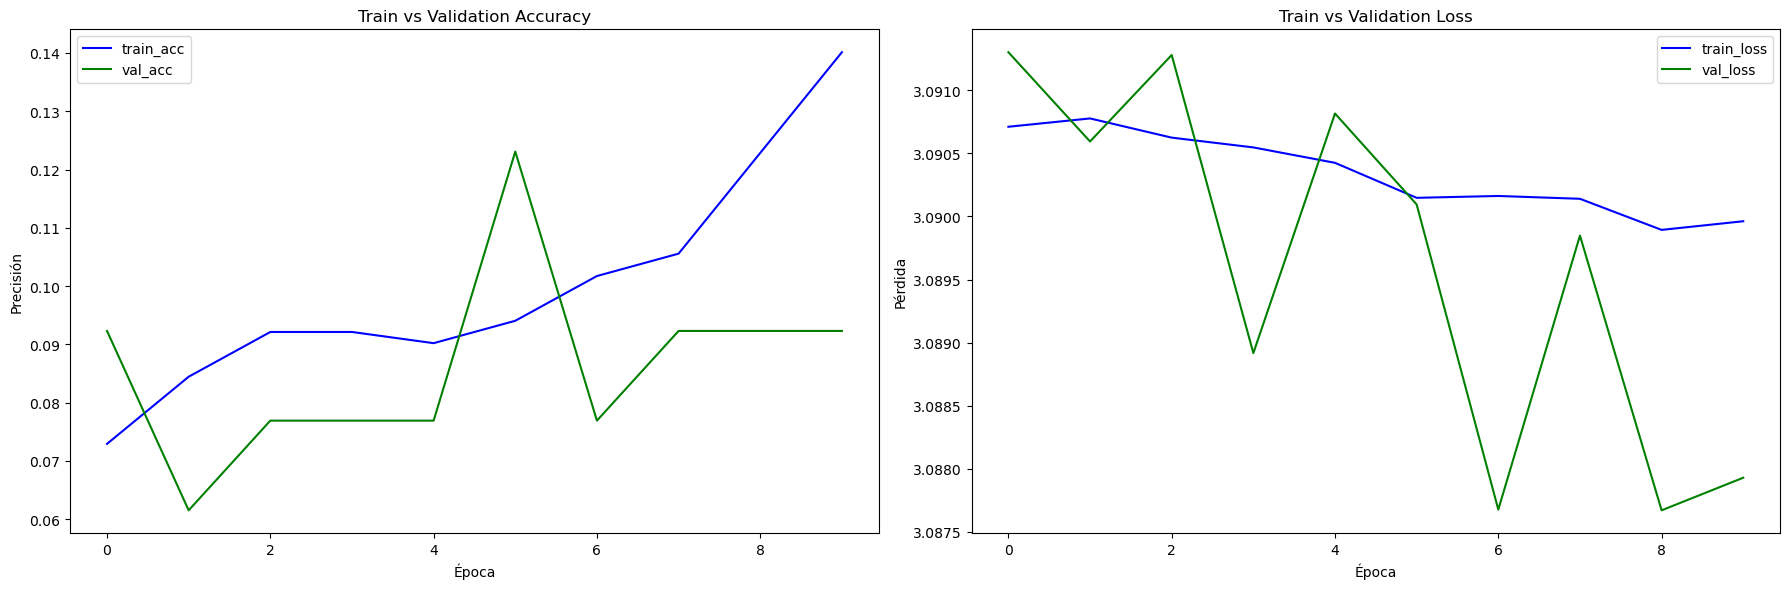

In [24]:
draw_metrics(train_acc, val_acc, train_loss, val_loss)

In [26]:
from torch import optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.load_state_dict(torch.load("models\\model.pth"))
model.to(device)


# Define the loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer)

# Number of epochs
EPOCHS = 20

# Lists to store training and validation results
train_acc = []

train_loss = []


val_acc = []

val_loss = []

for t in range(EPOCHS):
    print(f"Epoch {t + 1}/{EPOCHS}\n-------------------------------")

    # Training phase
    acc, loss = train(train_dataloader, model, loss_fn, optimizer)

    train_acc.append(acc)
    train_loss.append(loss)

    # Validation phase
    acc, loss = validate(val_dataloader, model, loss_fn)
    val_acc.append(acc)
    val_loss.append(loss)
    scheduler.step(loss)

    print(f"Validation accuraccy: {acc:.3f} | Validation mean_loss: {loss:.4f}\n-------------------------------")


print("Training and Validation Done!")

test_acc, test_loss = validate(test_dataloader, model, loss_fn)

print(f"Test accuraccy: {test_acc:.3f}| Test loss: {test_loss:.3f}\n-------------------------------")

# Save the trained model
torch.save(model.state_dict(), "models\\model.pth")
print("Model saved as model_cnn.pth")
draw_metrics(train_acc, val_acc, train_loss, val_loss)

Epoch 1/20
-------------------------------


C:\Users\adria\AppData\Local\Temp\ipykernel_21120\837851157.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs, labels = inputs.to(device), torch.tensor(labels).to(device)


Training accuraccy: 0.1305 | Training mean_loss: 3.0899
-------------------------------
Validation accuraccy: 0.123 | Validation mean_loss: 3.0897
-------------------------------
Epoch 2/20
-------------------------------
Training accuraccy: 0.1440 | Training mean_loss: 3.0897
-------------------------------
Validation accuraccy: 0.077 | Validation mean_loss: 3.0916
-------------------------------
Epoch 3/20
-------------------------------
Training accuraccy: 0.1689 | Training mean_loss: 3.0896
-------------------------------
Validation accuraccy: 0.123 | Validation mean_loss: 3.0901
-------------------------------
Epoch 4/20
-------------------------------
Training accuraccy: 0.1612 | Training mean_loss: 3.0896
-------------------------------
Validation accuraccy: 0.154 | Validation mean_loss: 3.0915
-------------------------------
Epoch 5/20
-------------------------------
Training accuraccy: 0.1574 | Training mean_loss: 3.0894
-------------------------------
Validation accuraccy: 0.

KeyboardInterrupt: 